In [ ]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15101 MiB


https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth

## Install Requirements

In [1]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 115.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.

In [2]:
!git lfs install
!git clone https://huggingface.co/datasets/Abdou-05/pottery

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'pottery'...
remote: Enumerating objects: 26, done.
remote: Total 26 (delta 0), reused 0 (delta 0), pack-reused 26
Unpacking objects: 100% (26/26), 3.76 KiB | 769.00 KiB/s, done.


In [3]:
#@title Login to HuggingFace 🤗

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
# https://huggingface.co/settings/tokens
!mkdir -p ~/.huggingface
HUGGINGFACE_TOKEN = "Draw a cat on a moroccan tile" #@param {type:"string"}
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token

## Settings and run

In [4]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = True #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Name/Path of the initial model.
MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "stable_diffusion_weights/zwx" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/content/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

Mounted at /content/drive
[*] Weights will be saved at /content/drive/MyDrive/stable_diffusion_weights/zwx


# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

In [5]:
# You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.

concepts_list = [
    {
        "instance_prompt":      "photo of zwx dog",
        "class_prompt":         "photo of a dog",
        "instance_data_dir":    "/content/data/zwx",
        "class_data_dir":       "/content/data/dog"
    },
#     {
#         "instance_prompt":      "photo of ukj person",
#         "class_prompt":         "photo of a person",
#         "instance_data_dir":    "/content/data/ukj",
#         "class_data_dir":       "/content/data/person"
#     }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
from torchvision.transforms import ToTensor

dataset = load_dataset("Abdou-05/pottery", split="train")

# Convert the image data to PyTorch tensors
images = [ToTensor()(image) for image in dataset['image']]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_hf_folder.py:92: UserWarning: A token has been found in `/root/.huggingface/token`. This is the old path where tokens were stored. The new location is `/root/.cache/huggingface/token` which is configurable using `HF_HOME` environment variable. Your token has been copied to this new location. You can now safely delete the old token file manually or use `huggingface-cli logout`.
  warnings.warn(


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/Abdou-05___imagefolder/Abdou-05--pottery-0af0116c37c2c93f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [6]:
#@markdown Upload your images by running this cell.

#@markdown OR

#@markdown You can use the file manager on the left panel to upload (drag and drop) to each `instance_data_dir` (it uploads faster). You can also upload your own class images in `class_data_dir` if u don't wanna generate with SD.

import os
from google.colab import files
import shutil

for c in concepts_list:
    print(f"Uploading instance images for `{c['instance_prompt']}`")
    uploaded = files.upload()
    for filename in uploaded.keys():
      if '.avif' not in filename:
        dst_path = os.path.join(c['instance_data_dir'], filename)
        shutil.move(filename, dst_path)

Uploading instance images for `photo of zwx dog`


Saving 5a030e4cf472d067b94a954a7b5305a8.jpeg to 5a030e4cf472d067b94a954a7b5305a8.jpeg
Saving 81+WtLAwdQL._AC_UL400_.jpg to 81+WtLAwdQL._AC_UL400_.jpg
Saving 81CxsdBjW5L._AC_UL400_.jpg to 81CxsdBjW5L._AC_UL400_.jpg
Saving 81D-ghZN-kL._AC_UL400_.jpg to 81D-ghZN-kL._AC_UL400_.jpg
Saving 81IFY5kLDmL._AC_UL400_.jpg to 81IFY5kLDmL._AC_UL400_.jpg
Saving 81kjXDQXFUL._AC_UL400_.jpg to 81kjXDQXFUL._AC_UL400_.jpg
Saving 81QTzKJKBsL.jpeg to 81QTzKJKBsL.jpeg
Saving 81xs3MyzbdL._AC_UL420_SR420,420_.jpg to 81xs3MyzbdL._AC_UL420_SR420,420_.jpg
Saving 91OxkZKF1xL.jpeg to 91OxkZKF1xL.jpeg
Saving 816BP0p8m1L._AC_SL1500_.jpg to 816BP0p8m1L._AC_SL1500_.jpg
Saving 918TLjdRBrL._AC_UL400_.jpg to 918TLjdRBrL._AC_UL400_.jpg
Saving DSC2358.jpeg to DSC2358.jpeg
Saving DSC07667medium1.jpeg to DSC07667medium1.jpeg
Saving il_570xN.3629165957_3dg9.jpg to il_570xN.3629165957_3dg9.jpg
Saving il_fullxfull.3057034287_rek0.jpg to il_fullxfull.3057034287_rek0.jpg
Saving il_fullxfull.3469590510_g1c1.jpg to il_fullxfull.3469

In [ ]:
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=800 \
  --save_interval=10000 \
  --save_sample_prompt="photo of zwx dog" \
  --concepts_list="concepts_list.json"

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

2023-05-07 06:33:56.281792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:249: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_hf_folder.py:92: UserWarning: A token has been found in `/root/.huggingface/token`. This is the old path where tokens were stored. The new location is `/root/.cache/huggingface/token` which is configurable using `HF_HOME` environment variable. Your token has been copied to this new location. You can now safely delete the old token file manually or use `huggingface-cli logout`.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found
Fetching 15 files:   0% 0/15 [00:00<?, ?it/s]



Fetching 15 files:  20% 3/15 [00:00<00:00, 29.35it/s]




















































In [ ]:
#@markdown Specify the weights directory to use (leave blank for latest)
WEIGHTS_DIR = "" #@param {type:"string"}
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

In [ ]:
#@markdown Run to generate a grid of preview images from the last saved weights.
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig('grid.png', dpi=72)

## Convert weights to ckpt to use in web UIs like AUTOMATIC1111.

In [ ]:
#@markdown Run conversion.
ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = True #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at /content/drive/MyDrive/stable_diffusion_weights/zwx/800/model.ckpt


## Inference

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler, ControlNetModel
from IPython.display import display

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

controlNet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained(model_path, controlnet=controlNet, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
g_cuda = None

Keyword arguments {'controlnet': ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
   

In [ ]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/24 [00:00<?, ?it/s]

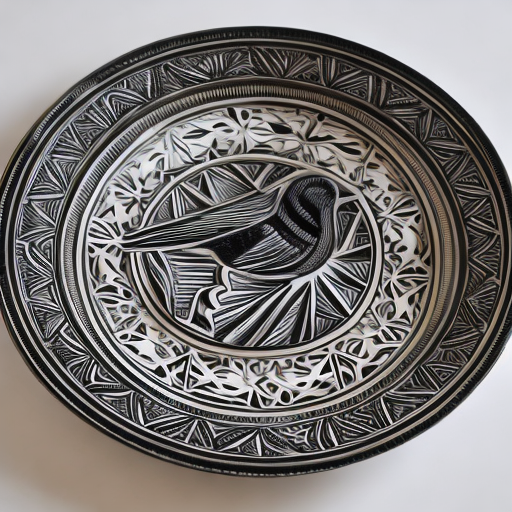

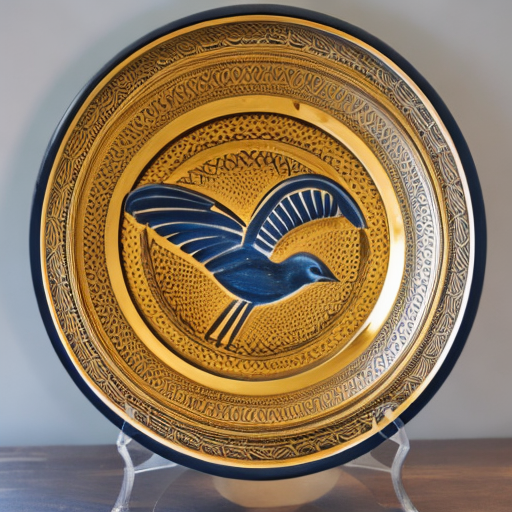

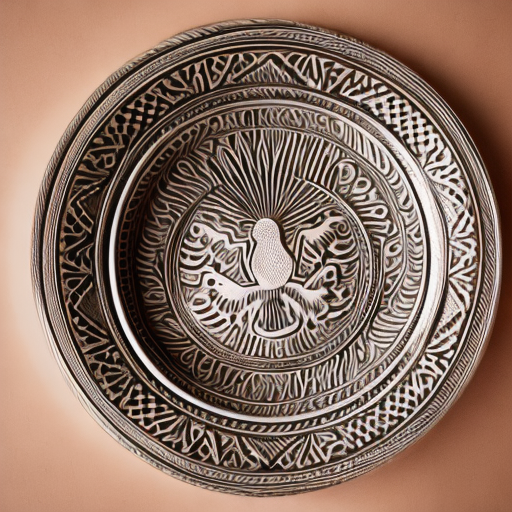

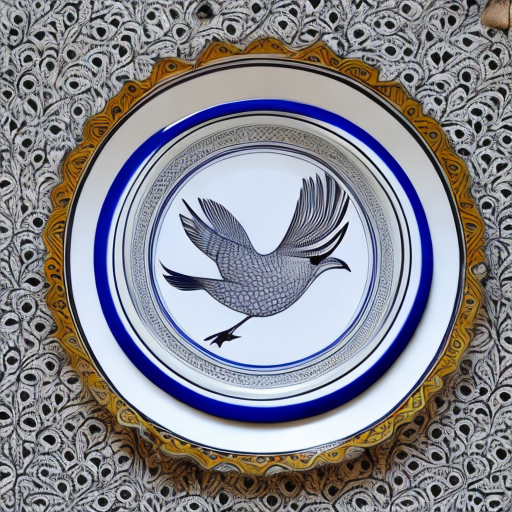

In [ ]:
#@title Run for generating images.

prompt = "a bird carved on a moroccan plate, high quality , high res, professional, realistic" #@param {type:"string"}
negative_prompt = "low res, low quality" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 24 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

DEMO